In [116]:
# Import all the necessary libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import datetime
# plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# For the machine learning model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [117]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install plotly
# !pip install scikit-learn

In [118]:
# # get out the current directory
# current_dir = os.getcwd()
# # get out the parent directory
# parent_dir = os.path.dirname(cuuser_dfrrent_dir)
# # change to the parent directory
# os.chdir(parent_dir)

In [119]:
path = "../inter-uni-datathon-2024-nsw/"
train_df = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")

In [120]:
!pip install imblearn

In [121]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority')
X_rus, y_rus = rus.fit_resample(train_df.drop(columns=['IsFraud']), train_df['IsFraud'])
train_df = pd.concat([X_rus, y_rus], axis=1)

In [122]:
# Age (does young adult cause more fraud?)
user_info = [
    "Age", 
    "Terrorism",
    "Income",
    "MaritalStatus",
    "Occupation",
    "EducationLevel",
    "NumDependents",
    "GiftsTransaction" 
]
transaction_info = [
    "TransactionType", 
    "TransactionDate",
    "TransactionTime", 
    "TransactionAmount",
    "TransactionLocation" 
]
account_info = [
    "UserTenure",
    "Expenditure",
    "Latitude",
    "Longitude" 
]

In [123]:
train_df

,TransactionNumber,UserID,Age,Gender,Occupation,EducationLevel,MaritalStatus,NumDependents,Income,Expenditure,...,MerchantID,TransactionType,TransactionLocation,DeviceType,Latitude,Longitude,EmailDomain,Terrorism,UserTenure,IsFraud
8565,2551,1865,22000,Female,Professional,Bachelor,Single,3,AU$ 92661.58,AU$ 52554.6,...,M002,Withdrawal,Melburn,Desktop,-31.840233,145.612793,davidsmith@gmail.com,False,41,0
8047,18139,872,29,Female,Student,High School,Married,2,AU$ 77729.72,AED 84918.21,...,M007,Purchase,Adelaide,Mobile,-20.917574,142.702789,velazquezgina@securemail.com,False,26,0
7809,15685,604,29,Male,Unemployed,Master,Single,3,173719.27 AUD,232219.29 AED,...,M008,Purchase,Sydney,galaxys7,-37.020100,144.964600,gilbertamanda@yahoo.com,False,75,0
1120,3988,376,46,fem,Professional,Master,Single,1,134357.88 AUD,AU$ 72386.52,...,M008,Purchase,Adelaide,Desktop,-30.000233,136.209152,fergusonjeremiah@yahoo.com,False,11,0
2185,8998,3487,34,Female,Student,Bachelor,Married,1,85524.36 AUD,AU$ 67413.8,...,M002,Payment,Melbourne,Mobile,-31.840233,145.612793,alicia43@securemail.com,False,113,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,16023,4468,30,Male,Professional,Bachelor,Married,1,AU$ 143566.54,258425.72 AED,...,M003,Purchase,Darwin,Desktop,-37.020100,144.964600,xoconnor@outlook.com,False,51,1
10956,11363,1399,35,Male,Professional,Master,Married,0,29584.49 AUD,10238.38 AUD,...,M005,Purchase,Adelaide,Tablet,-37.020100,144.964600,laura39@gmail.com,False,114,1
10962,11964,3925,-18,Female,Professional,High School,Married,2,80403.31 AUD,AU$ 63429.08,...,M003,Purchase,Hobart,iphone 15,-37.020100,144.964600,rcruz@yahoo.com,False,91,1
10964,860,1110,29,Female,Student,High School,Divorced,4,28654.66 AUD,AU$ 9748.53,...,M004,Purchase,Canberra,Mobile,-37.020100,144.964600,miranda86@disposable.com,False,62,1


## Cleaning

### Clean currency data (4 columns)

In [124]:
import re
import pandas as pd

def get_currency_and_symbol(val):
    if 'AUD' in val or 'AU' in val:
        # create a feature for aud
        return re.sub(r'[^\d.]', '', val), 'AUD' 
    elif 'AED' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert AED to AUD
        return float(value) * 0.35, 'AED'
    elif '£' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    elif 'GBP' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    else:
        return "Unidentified", "Unknown" 


# Apply to Income
train_df['Income'], train_df['Income_Currency'] = zip(*train_df['Income'].apply(get_currency_and_symbol))
train_df['Income'] = pd.to_numeric(train_df['Income'], errors='coerce')  

# Apply to Expenditure
train_df['Expenditure'], train_df['Expenditure_Currency'] = zip(*train_df['Expenditure'].apply(get_currency_and_symbol))
train_df['Expenditure'] = pd.to_numeric(train_df['Expenditure'], errors='coerce')

# Apply to GiftsTransaction
train_df['GiftsTransaction'], train_df['GiftsTransaction_Currency'] = zip(*train_df['GiftsTransaction'].apply(get_currency_and_symbol))
train_df['GiftsTransaction'] = pd.to_numeric(train_df['GiftsTransaction'], errors='coerce')

# Apply to TransactionAmount
train_df['TransactionAmount'], train_df['TransactionAmount_Currency'] = zip(*train_df['TransactionAmount'].apply(get_currency_and_symbol))
train_df['TransactionAmount'] = pd.to_numeric(train_df['TransactionAmount'], errors='coerce') 

# Drop the original columns
train_df.drop(columns=['Income', 'Expenditure', 'GiftsTransaction', 'TransactionAmount'], inplace=True)


In [125]:
# # Check if there's any missing values
# train_df['Income'].isnull().sum()
# train_df[train_df['Income'] == 'Unidentified']
# # expenditure
# train_df['Expenditure'].isnull().sum()
# train_df[train_df['Expenditure'] == 'Unidentified']
# # giftsTransaction
# train_df['GiftsTransaction'].isnull().sum()
# train_df[train_df['GiftsTransaction'] == 'Unidentified']
# # TransactionAmountggV
# train_df['TransactionAmount'].isnull().sum()
# train_df[train_df['TransactionAmount'] == 'Unidentified']

In [126]:
# Convert categorical data to numerical data through One Hot Encoding
user_df = pd.get_dummies(train_df[user_info])
transaction_df = pd.get_dummies(train_df[transaction_info])
account_df = pd.get_dummies(train_df[account_info])
# Append IsFraud to the all dfs
user_df['IsFraud'] = train_df['IsFraud']
transaction_df['IsFraud'] = train_df['IsFraud']
account_df['IsFraud'] = train_df['IsFraud']

KeyError: "['Income', 'GiftsTransaction'] not in index"

In [15]:
# Calculate correlations once for each DataFrame
user_corr = user_df.corrwith(user_df['IsFraud'])
transaction_corr = transaction_df.corrwith(transaction_df['IsFraud'])
account_corr = account_df.corrwith(account_df['IsFraud'])

# Sort the correlations in descending order
user_corr = user_corr.sort_values(ascending=False)
transaction_corr = transaction_corr.sort_values(ascending=False)
account_corr = account_corr.sort_values(ascending=False)


In [20]:
user_corr.head(10)

IsFraud                    1.000000
MaritalStatus_Divorced     0.032624
EducationLevel_PhD         0.020876
Occupation_Unemployed      0.015259
GiftsTransaction           0.014263
Terrorism                  0.013633
Income                     0.012592
MaritalStatus_Widowed      0.008158
Occupation_Student         0.007891
EducationLevel_Bachelor   -0.001135
dtype: float64

In [19]:
transaction_corr.head(10)

IsFraud                         1.000000
TransactionType_Withdrawal      0.557298
TransactionTime_00:00:00        0.153296
TransactionAmount               0.103385
TransactionTime_00/00/00        0.054156
TransactionTime_12:00:00 AM     0.050333
TransactionLocation_Brisbane    0.043807
TransactionLocation_Perth       0.039812
TransactionDate_2023-05-26      0.034838
TransactionLocation_Hobart      0.033201
dtype: float64

In [18]:
account_corr

IsFraud        1.000000
Expenditure    0.011879
Latitude       0.005265
UserTenure     0.004936
Longitude      0.003647
dtype: float64

## EDA

In [73]:
# make default plot smaller
plt.rcParams['figure.figsize'] = [12, 3]

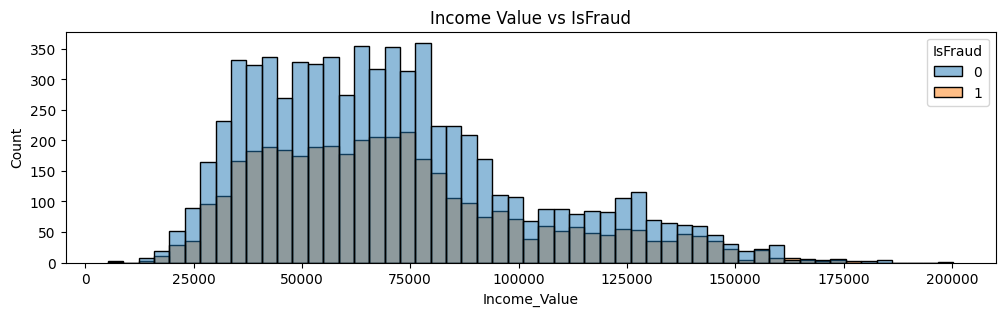

In [74]:
# Plot the income against the isFraud, histogram
sns.histplot(x='Income', hue='IsFraud', data=train_df)
plt.title('Income Value vs IsFraud')
plt.show()

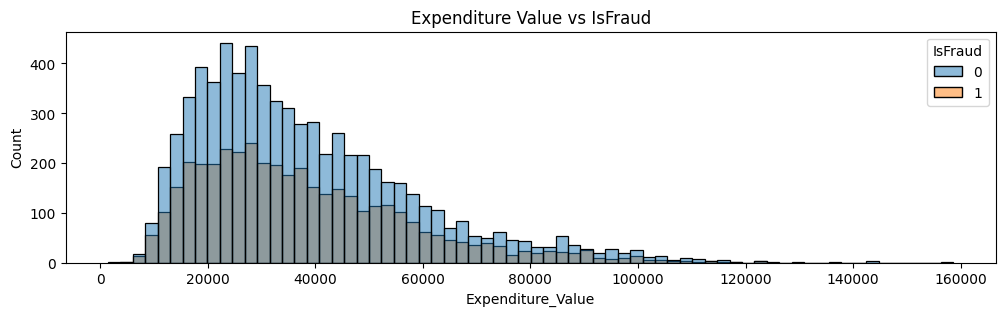

In [75]:
# Plot expenditure value against the isFraud, histogram
sns.histplot(x='Expenditure', hue='IsFraud', data=train_df)
plt.title('Expenditure Value vs IsFraud')
plt.show()

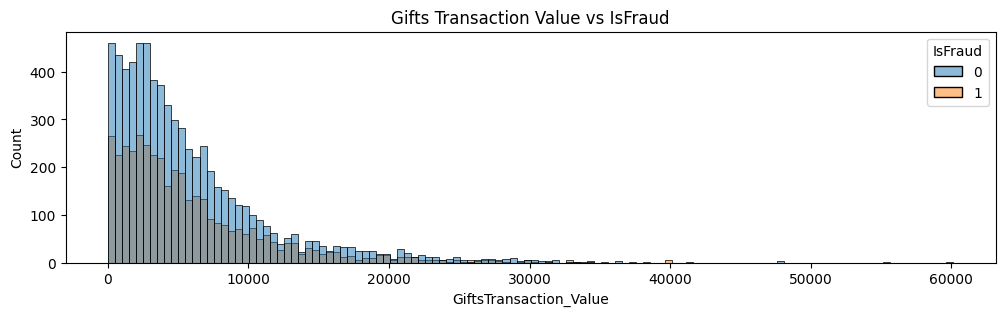

In [76]:
# Plot gifts transaction value against the isFraud, histogram
sns.histplot(x='GiftsTransaction', hue='IsFraud', data=train_df)
plt.title('Gifts Transaction Value vs IsFraud')
plt.show()

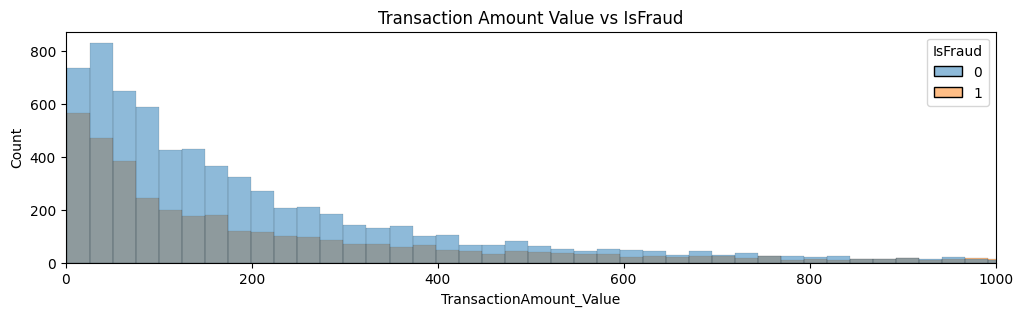

In [81]:
# Plot transaction amount value against the isFraud, histogram, zoom into the range of 0 to 1000
sns.histplot(x='TransactionAmount', hue='IsFraud', data=train_df)
plt.xlim(0, 1000)
plt.title('Transaction Amount Value vs IsFraud')
plt.show()

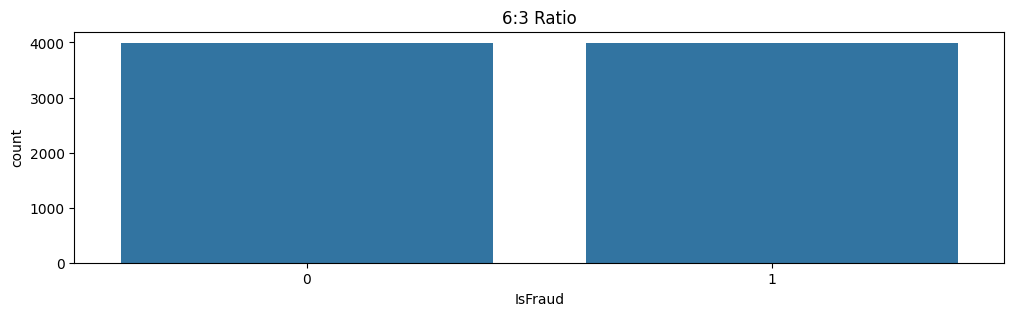

In [93]:
# Check the number of 0 and 1 in the IsFraud column, gimme ratio
train_df['IsFraud'].value_counts(normalize=True)
# Barplot it
sns.countplot(x='IsFraud', data=train_df)
plt.title('6:3 Ratio')
plt.show()

In [79]:
# Check correlation between the features: Income, Expenditure, GiftsTransaction, TransactionAmount, and IsFraud
train_df[['Income', 'Expenditure', 'GiftsTransaction', 'TransactionAmount', 'IsFraud']].corr()

,Income_Value,Expenditure_Value,GiftsTransaction_Value,TransactionAmount_Value,IsFraud
Income_Value,1.000000,0.828327,0.430414,0.007138,0.012592
Expenditure_Value,0.828327,1.000000,0.348032,0.006279,-0.001874
GiftsTransaction_Value,0.430414,0.348032,1.000000,-0.006143,0.007202
TransactionAmount_Value,0.007138,0.006279,-0.006143,1.000000,0.114700
IsFraud,0.012592,-0.001874,0.007202,0.114700,1.000000


=> Transaction amount, expenditure, and gift transaction values have little correlation with is Fraud